# Confectionary Sales – Exploratory Data Analysis

_Course: Programming for Data Analytics_

- Name: Muhammad Umar Uz Zaman
- Student ID: STU1197819
- Goal: Explore UK confectionary sales to understand:
  - How sales and profitability differ between UK regions
  - Which confectionery products have the highest and lowest profit margins
  - How regional sales change over time
- Dataset: `confectionary.xlsx` (sales records for multiple UK regions)

**Phases of this notebook**

Intro & setup  
Phase 1 – Data loading & structure check  
Phase 2 – Data cleaning & preparation  
Phase 3 – Core EDA (distributions & relationships)  
Phase 4 – Targeted analysis for assignment questions  
Phase 5 – Visualisation design & dashboard prep  
Phase 6 – Wrap-up & export for report


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

plt.style.use("seaborn-v0_8")
sns.set_theme()

# Load data
file_path = "confectionary.xlsx" 
df = pd.read_excel(file_path)

print("Shape:", df.shape)
df.head()


Shape: (1001, 7)


,Date,Country(UK),Confectionary,Units Sold,Cost(£),Profit(£),Revenue(£)
0,2002-11-11,England,Biscuit,"1,118.00","2,459.60","3,130.40","749,954.40"
1,2002-07-05,England,Biscuit,708.00,"1,557.60","1,982.40","300,758.40"
2,2001-10-31,England,Biscuit,"1,269.00","2,791.80","3,553.20","966,216.60"
3,2004-09-13,England,Biscuit,"1,631.00","3,588.20","4,566.80","1,596,096.60"
4,2004-03-10,England,Biscuit,"2,240.00","4,928.00","6,272.00","3,010,560.00"


## 1. Data loading and initial inspection


In [3]:
print("=== DataFrame info ===")
print(df.info())

print("\n=== Missing values per column ===")
print(df.isna().sum())

print("\n=== Basic numeric summary ===")
display(df.describe())

print("\n=== Unique values: Country(UK) ===")
print(df["Country(UK)"].value_counts(dropna=False))

print("\n=== Unique values: Confectionary ===")
print(df["Confectionary"].value_counts(dropna=False))


=== DataFrame info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1001 non-null   datetime64[ns]
 1   Country(UK)    1001 non-null   object        
 2   Confectionary  1001 non-null   object        
 3   Units Sold     996 non-null    float64       
 4   Cost(£)        992 non-null    float64       
 5   Profit(£)      998 non-null    float64       
 6   Revenue(£)     1001 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 54.9+ KB
None

=== Missing values per column ===
Date             0
Country(UK)      0
Confectionary    0
Units Sold       5
Cost(£)          9
Profit(£)        3
Revenue(£)       0
dtype: int64

=== Basic numeric summary ===


,Date,Units Sold,Cost(£),Profit(£),Revenue(£)
count,1001,996.00,992.00,998.00,"1,001.00"
mean,2002-11-19 10:54:32.727272832,"1,633.36","2,820.19","4,012.08","2,519,449.31"
min,2000-01-02 00:00:00,200.00,40.00,160.00,"-21,962,259.00"
25%,2001-05-12 00:00:00,923.00,"1,204.00","1,872.40","576,240.00"
50%,2002-11-10 00:00:00,"1,530.50","2,456.80","3,459.00","1,627,208.00"
75%,2004-04-25 00:00:00,"2,300.00","3,977.62","5,445.00","3,551,112.50"
max,2005-12-28 00:00:00,"4,493.00","10,994.50","13,479.00","20,187,049.00"
std,NaN,876.36,"2,073.97","2,648.17","2,941,639.44"



=== Unique values: Country(UK) ===
Country(UK)
Scotland      210
N. Ireland    210
Wales         210
Jersey        210
England       161
Name: count, dtype: int64

=== Unique values: Confectionary ===
Confectionary
Caramel            345
Choclate Chunk     130
Biscuit Nut        125
Biscuit            124
Plain              112
Caramel nut         82
Caramel Nut         67
Chocolate Chunk     16
Name: count, dtype: int64


- 1,001 rows and 7 columns covering confectionary sales.
- Date is already in a proper datetime format.
- Small amount of missing numeric data:
  - Units Sold: 5, Cost: 9, Profit: 3 (Revenue has no missing values).
- Regions:
  - Scotland, N. Ireland, Wales, Jersey each have 210 records.
  - England has 161 records (slightly fewer data points).
- Confectionary categories show clear spelling variants:
  - `Choclate Chunk` vs `Chocolate Chunk`
  - `Caramel nut` vs `Caramel Nut`
- Numeric summary shows a very large **negative Revenue minimum**, which is unusual and suggests either
  data entry issues or special cases like returns. We’ll investigate this before doing any profit-margin analysis.

Next we clean category labels, handle missing values, and investigate Revenue anomalies.


## Phase 2 – Data Cleaning & Preparation

In this phase we will:

1. Keep a copy of the raw data for reference.
2. Standardise confectionary labels (fix obvious typos / inconsistent spelling).
3. Handle missing values in key numeric fields (Units Sold, Cost, Profit).
4. Investigate unusual or non-positive Revenue values.
5. Prepare a cleaned dataset for further EDA in Phase 3.


In [4]:
# Keep a pristine copy of the original data
df_raw = df.copy()

# Standardise confectionary spelling / capitalisation
confectionary_recode = {
    "Choclate Chunk": "Chocolate Chunk",  # fix typo
    "Caramel nut": "Caramel Nut"         # normalise case
    # We keep 'Caramel' vs 'Caramel Nut' as separate products for now
}

df["Confectionary"] = (
    df["Confectionary"]
    .str.strip()
    .replace(confectionary_recode)
)

print("=== Confectionary counts AFTER cleaning ===")
print(df["Confectionary"].value_counts())


=== Confectionary counts AFTER cleaning ===
Confectionary
Caramel            345
Caramel Nut        149
Chocolate Chunk    146
Biscuit Nut        125
Biscuit            124
Plain              112
Name: count, dtype: int64



- Fixed obvious spelling errors:
  - `Choclate Chunk` → `Chocolate Chunk`
  - `Caramel nut` → `Caramel Nut`
- Left `Caramel` and `Caramel Nut` as **separate products**, assuming they are distinct SKUs
  rather than data entry mistakes.
- This step ensures that counts, totals, and profit margins for each product are not artificially split
  due to typos, which is important when we later identify the best and worst performing confectionery
  in each region.
- Now we handle the missing values


In [5]:
core_numeric = ["Units Sold", "Cost(£)", "Profit(£)", "Revenue(£)"]

print("=== Missing values BEFORE numeric cleaning ===")
print(df[core_numeric].isna().sum())

# Drop rows where Units Sold, Cost, or Profit are missing
df_clean = df.dropna(subset=["Units Sold", "Cost(£)", "Profit(£)"]).copy()

print("\nOriginal rows:", len(df))
print("Rows after dropping NA in Units/Cost/Profit:", len(df_clean))

print("\n=== Missing values AFTER numeric cleaning ===")
print(df_clean[core_numeric].isna().sum())


=== Missing values BEFORE numeric cleaning ===
Units Sold    5
Cost(£)       9
Profit(£)     3
Revenue(£)    0
dtype: int64

Original rows: 1001
Rows after dropping NA in Units/Cost/Profit: 984

=== Missing values AFTER numeric cleaning ===
Units Sold    0
Cost(£)       0
Profit(£)     0
Revenue(£)    0
dtype: int64


- `Units Sold`, `Cost(£)`, and `Profit(£)` are essential for profitability analysis.
- These columns have only a small number of missing values (roughly 1–2% of rows).
- For clarity and to avoid complex imputation that could distort margins, we:
  - Removed rows with missing values in any of `Units Sold`, `Cost(£)`, or `Profit(£)`.
- The resulting `df_clean` dataset keeps the vast majority of observations while ensuring
  all core financial metrics are available for each record.


In [6]:
print("=== Revenue summary (df_clean) ===")
display(df_clean["Revenue(£)"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

# Rows with non-positive revenue
anomalous_revenue = df_clean[df_clean["Revenue(£)"] <= 0]

print("\nNumber of rows with Revenue <= 0:", len(anomalous_revenue))
display(
    anomalous_revenue[
        ["Date", "Country(UK)", "Confectionary",
         "Units Sold", "Cost(£)", "Profit(£)", "Revenue(£)"]
    ].head(10)
)


=== Revenue summary (df_clean) ===


count          984.00
mean     2,552,825.55
std      2,822,196.00
min         24,000.00
1%          40,248.60
5%          93,637.88
50%      1,630,818.00
95%      7,789,681.00
99%     13,665,760.92
max     20,187,049.00
Name: Revenue(£), dtype: float64


Number of rows with Revenue <= 0: 0


,Date,Country(UK),Confectionary,Units Sold,Cost(£),Profit(£),Revenue(£)


In [7]:
# Profit margin: Profit / Revenue
df_clean["Profit_Margin"] = df_clean["Profit(£)"] / df_clean["Revenue(£)"]

# Time features
df_clean["Year"] = df_clean["Date"].dt.year
df_clean["Month"] = df_clean["Date"].dt.to_period("M").astype(str)

print("=== Profit margin summary ===")
print(df_clean["Profit_Margin"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

# Check for strange margins: negative or > 1 (profit higher than revenue)
margin_outliers = df_clean[
    (df_clean["Profit_Margin"] < 0) | (df_clean["Profit_Margin"] > 1)
]

print("\nNumber of rows with Profit_Margin < 0 or > 1:", len(margin_outliers))
display(
    margin_outliers[
        ["Date", "Country(UK)", "Confectionary", "Profit(£)", "Revenue(£)", "Profit_Margin"]
    ].head(10)
)


=== Profit margin summary ===
count   984.00
mean      0.00
std       0.00
min       0.00
1%        0.00
5%        0.00
50%       0.00
95%       0.01
99%       0.02
max       0.03
Name: Profit_Margin, dtype: float64

Number of rows with Profit_Margin < 0 or > 1: 0


,Date,Country(UK),Confectionary,Profit(£),Revenue(£),Profit_Margin


#### 2.1 Feature engineering – profit margins and time

- Added a `Profit_Margin` feature defined as `Profit(£) / Revenue(£)` for each record.
  - This gives a scale-free measure that allows fair comparison of confectionery products and regions,
    regardless of absolute revenue.
- Added basic time features:
  - `Year` – calendar year of the transaction.
  - `Month` – year-month period (e.g. `"2003-05"`).
- These features will be used later to:
  - Identify which confectionery has the highest and lowest profit margins in each region.
  - Analyse how regional sales and profitability change over time.
- We also inspected extreme profit margins (negative or > 1) to check for data quality issues,
  and will decide how to treat them in the analysis.


In [8]:
# More precise view of profit margins (4 decimals)
pm_summary = df_clean["Profit_Margin"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
pm_summary.apply(lambda x: f"{x:.4f}")


count    984.0000
mean       0.0034
std        0.0034
min        0.0004
1%         0.0005
5%         0.0007
50%        0.0022
95%        0.0108
99%        0.0170
max        0.0270
Name: Profit_Margin, dtype: object

- Profit margins are all small but sensible, roughly between 0% and 3%,
  and there are no negative or >100% margins, suggesting no major data-quality issues.


In [9]:
df_analysis = df_clean.copy()

print("df_analysis shape:", df_analysis.shape)
df_analysis.head()


df_analysis shape: (984, 10)


,Date,Country(UK),Confectionary,Units Sold,Cost(£),Profit(£),Revenue(£),Profit_Margin,Year,Month
0,2002-11-11,England,Biscuit,"1,118.00","2,459.60","3,130.40","749,954.40",0.00,2002,2002-11
1,2002-07-05,England,Biscuit,708.00,"1,557.60","1,982.40","300,758.40",0.01,2002,2002-07
2,2001-10-31,England,Biscuit,"1,269.00","2,791.80","3,553.20","966,216.60",0.00,2001,2001-10
3,2004-09-13,England,Biscuit,"1,631.00","3,588.20","4,566.80","1,596,096.60",0.00,2004,2004-09
4,2004-03-10,England,Biscuit,"2,240.00","4,928.00","6,272.00","3,010,560.00",0.00,2004,2004-03


#### 2.2 Final analysis dataset

- `df_analysis` is the main dataset for all further EDA and visualisation.
- It contains:
  - 984 rows after removing records with missing Units Sold, Cost or Profit.
  - Cleaned confectionary labels.
  - Engineered features: `Profit_Margin`, `Year`, `Month`.


### Phase 3 – Core Exploratory Data Analysis

In this phase we explore:

1. Overall regional and product-level summaries.
2. Distributions of key numeric variables (Units Sold, Revenue, Profit, Profit Margin).
3. Relationships between metrics (correlations and basic scatter plots).

This will inform which visualisations are most appropriate for the final report and dashboard.


In [10]:
region_summary = (
    df_analysis
    .groupby("Country(UK)")
    .agg(
        Records=("Country(UK)", "size"),
        Total_Units=("Units Sold", "sum"),
        Total_Revenue=("Revenue(£)", "sum"),
        Total_Profit=("Profit(£)", "sum"),
        Avg_Profit_Margin=("Profit_Margin", "mean")
    )
    .reset_index()
)

region_summary["Avg_Profit_Margin_pct"] = region_summary["Avg_Profit_Margin"] * 100

region_summary


,Country(UK),Records,Total_Units,Total_Revenue,Total_Profit,Avg_Profit_Margin,Avg_Profit_Margin_pct
0,England,156,"272,044.00","424,584,483.50","677,189.25",0.00,0.31
1,Jersey,206,"364,190.00","628,042,403.50","899,044.05",0.00,0.32
2,N. Ireland,208,"305,086.00","434,023,594.80","740,528.00",0.00,0.38
3,Scotland,207,"374,062.00","633,388,869.00","926,335.40",0.00,0.27
4,Wales,207,"292,079.00","391,940,994.40","718,444.20",0.00,0.40


#### 3.1 Regional overview 

- **Data coverage**
  - Records are fairly balanced across regions (≈200 rows each), with **England** having the fewest records (156) and **Jersey / N. Ireland / Scotland / Wales** around 200+ each.
  - This means regional comparisons are not dominated by a single region having vastly more rows.

- **Sales volume and revenue**
  - **Scotland** has the highest **total units sold** (~374k) and the highest **total revenue** (~£633m).
  - **Jersey** is a close second in revenue (~£628m) with slightly fewer units than Scotland.
  - **Wales** shows the lowest total revenue (~£392m), reflecting smaller overall market size in this dataset.

- **Profit levels**
  - **Scotland** also generates the highest **total profit** (~£926k), followed by **Jersey** (~£899k).
  - **England** has the lowest total profit (~£677k), consistent with having fewer records and lower total units.

- **Average profit margins**
  - Average margins are low but consistent across regions (roughly **0.27–0.40%**).
  - **Wales** shows the **highest average profit margin** (~0.40%), followed by **N. Ireland** (~0.38%).
  - **Scotland**, despite leading in revenue and profit, has a slightly **lower average margin** (~0.27%), suggesting a focus on volume rather than margin per sale.

- **Implications for further analysis**
  - Scotland and Jersey look like the **“big markets”** in absolute terms and will be important for volume-driven decisions.
  - Wales and N. Ireland, though smaller in revenue, appear **more efficient** on a margin basis and are worth exploring for best-practice pricing or product mix.
  - Later sections will break these patterns down by **confectionery type** and **over time** to see where these regional differences come from.


#### 3.2 Distributions of key numeric metrics

In this section we look at how the main numeric variables are distributed:

- Units Sold  
- Revenue(£)  
- Profit(£)  
- Profit_Margin  

This helps us understand skew, outliers and the overall “shape” of the data before
we compare regions or confectionery types.


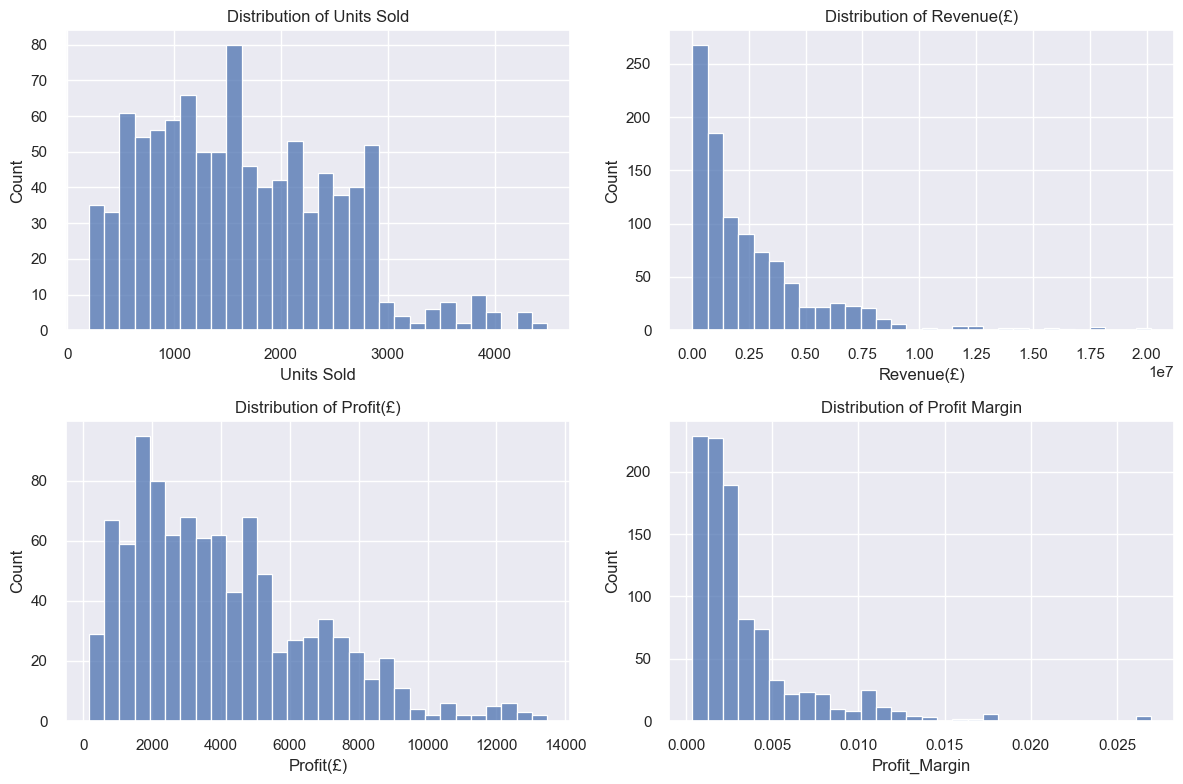

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df_analysis["Units Sold"], bins=30, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Units Sold")

sns.histplot(df_analysis["Revenue(£)"], bins=30, ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Revenue(£)")

sns.histplot(df_analysis["Profit(£)"], bins=30, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Profit(£)")

sns.histplot(df_analysis["Profit_Margin"], bins=30, ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Profit Margin")

plt.tight_layout()
plt.show()


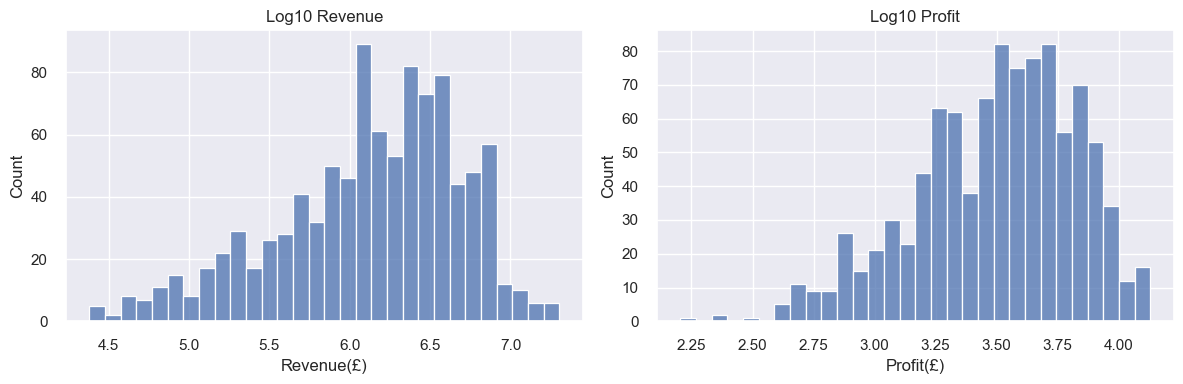

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(np.log10(df_analysis["Revenue(£)"]), bins=30, ax=axes[0])
axes[0].set_title("Log10 Revenue")

sns.histplot(np.log10(df_analysis["Profit(£)"]), bins=30, ax=axes[1])
axes[1].set_title("Log10 Profit")

plt.tight_layout()
plt.show()


- **Units Sold**
  - Most observations sit roughly between **800 and 2,500 units**, with a long but thin tail up to ~4,500.
  - The shape is mildly right-skewed: high-volume orders exist but are relatively rare.

- **Revenue(£)**
  - Strongly **right-skewed**: many transactions are clustered at lower revenue levels, with a few very large orders
    stretching out towards ~£20m.
  - After applying a log10 transform, revenue becomes much closer to a symmetric, bell-shaped distribution,
    confirming that multiplicative (rather than additive) variation dominates.

- **Profit(£)**
  - Profit shows a similar right-skew to revenue, with most observations in the lower range and a small number of
    very high-profit orders.
  - On the log10 scale, profit is also approximately symmetric, again suggesting that analysing profit differences
    on a log scale or via medians is more robust than relying only on means.

- **Profit_Margin**
  - Profit margins are tightly concentrated between roughly **0% and 3%**, with a high peak near very low margins
    and a thin right tail of slightly higher margins.
  - There are no extreme negative or >100% values, indicating that pricing and cost entries are internally consistent.

Overall, the heavy skew in **Revenue** and **Profit** implies that:
- We should use **medians** and/or log-scale visualisations when comparing regions or confectionery types.
- Small differences in **Profit_Margin** may still be meaningful given the very large absolute revenue figures.


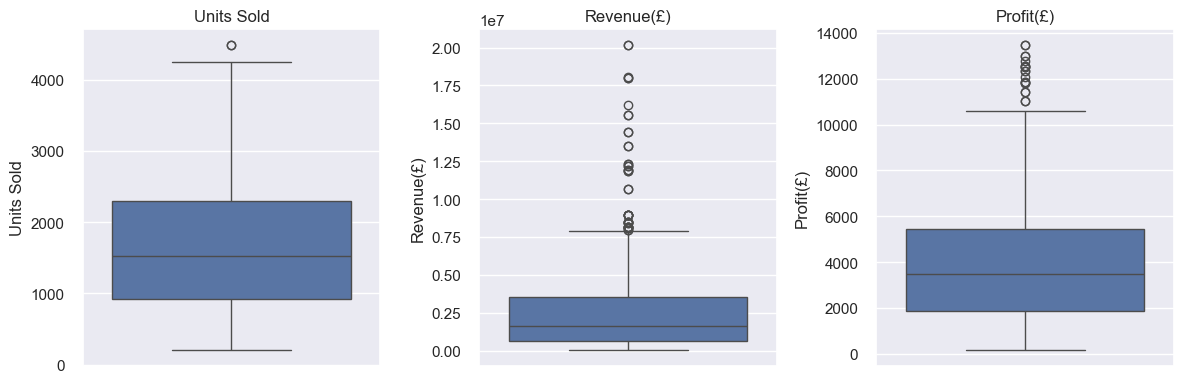

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(y=df_analysis["Units Sold"], ax=axes[0])
axes[0].set_title("Units Sold")

sns.boxplot(y=df_analysis["Revenue(£)"], ax=axes[1])
axes[1].set_title("Revenue(£)")

sns.boxplot(y=df_analysis["Profit(£)"], ax=axes[2])
axes[2].set_title("Profit(£)")

plt.tight_layout()
plt.show()


- **Units Sold**
  - Median units per transaction sit around the mid-range (roughly 1,400–1,600 units).
  - The IQR is fairly tight, but there is a clear right tail with a few high-volume outliers above 4,000 units.
  - This supports the idea of a core “typical order size” plus a small number of very large orders.

- **Revenue(£)**
  - The boxplot shows a compressed central box and a very long upper whisker with many outlier points.
  - Most transactions lie well below the upper tail, while a handful of orders reach up towards ~£20m.
  - Revenue is therefore heavily dominated by a few big transactions, consistent with the histogram and log-scale view.

- **Profit(£)**
  - Profit displays the same pattern as revenue: a concentrated middle with a long upper tail and many high-profit outliers.
  - These high-profit orders will contribute disproportionately to total profit, so it is important to consider both totals and
    medians when comparing regions or confectionery types.

Overall, the boxplots confirm strong positive skew in **Revenue** and **Profit**, with a few very large
transactions driving the upper tails. This justifies:
- Using medians alongside totals for comparisons.
- Considering log-scale visualisations when we want to compare distributions across groups.
